## Assignment 3 Question 2

In [1]:
#Code written by Ryan Howarth, 251109839
import matplotlib.pyplot as plt
import numpy as np
!pip install opencv-python
import cv2

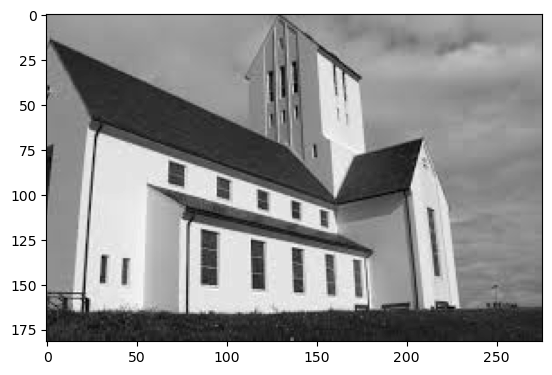

In [2]:
image1 = cv2.imread('image1.jfif', cv2.IMREAD_GRAYSCALE)
image1.shape
plt.imshow(image1, cmap = 'gray')

In [3]:
#Image smoothing

#Using 5x5 Kernel mask
def gausKernel(sigma):

    gKernel = np.zeros((5, 5))

    #Since the kernel must be symmetrical, the index -2 to 2 is used (-2, -1, 0, 1, 2)
    for x in range(-2, 3):
        for y in range(-2, 3):
            gKernel[x, y] = (1 / 2 * np.pi * sigma**2) * np.exp(-((x**2 + y**2) / 2 * sigma**2))

    return gKernel

def gausConvolution(img, kernel):

    #Ix and Iy have to use size[] due to using PIL to import the image
    Ix = img.shape[0]
    Iy = img.shape[1]
    Gx = kernel.shape[0]
    Gy = kernel.shape[1]

    #Flip the mask in both dimensions and do the cross correlation
    kernel = np.flipud(kernel)
    kernel = np.fliplr(kernel)

    #Size of the output
    newImg = np.zeros(img.shape)
    newImg[0:Ix, 0:Iy] = img

    #Since it's separable we're doing rows then cols
    for x in range(0, Ix - Gx):
        for y in range(0, Iy - Gy):
            newImg[x, y] = np.sum(kernel * newImg[x: x + Gx, y: y + Gy])

    return newImg

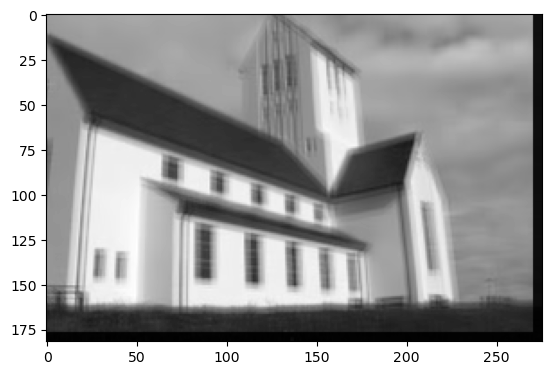

In [4]:
kernel = gausKernel(1)
img = gausConvolution(image1, kernel)
plt.imshow(img, cmap = 'gray')

In [5]:
#Gradient and Direction Calculation
def sobel(img):

    #Sobel filters and convolution
    sX = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sY = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    Ix, Iy = gausConvolution(image1, sX), gausConvolution(image1, sY)
    
    #Calculating the gradient
    gradient = np.sqrt(Ix**2 + Iy**2)
    
    #Setting the directions to degrees and then rounding to the nearest 45 for ease in finding the neighbours
    direction = np.arctan2(Iy, Ix) * 180 / np.pi
    dirRounded = np.round(direction / 45) * 45

    return (gradient, dirRounded)

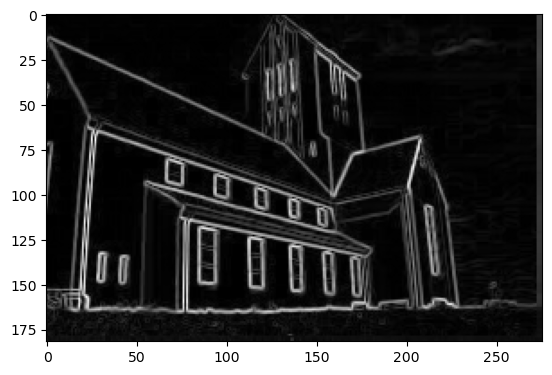

In [6]:
SOBELimg, dir = sobel(img)
plt.imshow(SOBELimg, cmap = 'gray')

In [7]:
#Eliminating pixels not local maxima
def nonMaxSup(img, direction):

    #Creating output array
    nonMS = np.zeros(img.shape)

    #Looping through each pixel to check their neighbours (indexing is 1 - shape - 1 to account for neighbour pixel indexing)
    for x in range(1, img.shape[0] - 1):
        for y in range(1, img.shape[1] - 1):
            #Setting beginning neighbours to 0
            p, r = 0, 0
            
            #Checking the angle of the magnitude to figure out the neighbouring pixels
            if (direction[x, y] == 0 or direction[x, y] == 180):
                p = img[x - 1, y]
                r = img[x + 1, y]
            elif (direction[x, y] == 45):
                p = img[x - 1, y - 1]
                r = img[x + 1, y + 1]
            elif (direction[x, y] == 90):
                p = img[x, y - 1]
                r = img[x, y + 1]
            else:
                p = img[x - 1, y + 1]
                r = img[x + 1, y - 1]

            if (img[x, y] < p or img[x, y] < r):
                nonMS[x, y] = 0
            else:
                nonMS[x, y] = img[x, y]

    return nonMS

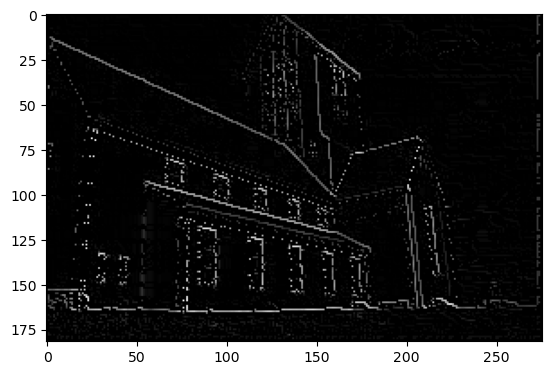

In [8]:
NMSimg = nonMaxSup(SOBELimg, dir)
plt.imshow(NMSimg, cmap = 'gray')

In [9]:
#Hysteresis Thresholding
def hystThresh(img, lowT, highT):

    #Selecting pixels where the magintude is > highT
    pHigh = np.where(img > highT)
    img[pHigh[0], pHigh[1]] = 250

    #Selecting the pixels inbetween lowT and highT
    pMid = np.where((img >= lowT) & (img <= highT))
    img[pMid[0], pMid[1]] = 50

    #Once again the range is 1 to img.shape - 1 due to the neighbouring pixels indexing
    for x in range(1, img.shape[0] - 1):
        for y in range(1, img.shape[1] - 1):
            #Check to see if the mid pixels have a highT neighbour, if so then keep them
            if (img[x, y] == 50):
                #Check all the neighbours (separated for ease of viewing)
                if (img[x - 1, y] or img[x + 1, y] == 250):
                    img[x, y] = 250
                elif (img[x, y - 1] or img[x, y + 1] == 250):
                    img[x, y] = 250
                elif (img[x - 1, y - 1] or img[x + 1, y + 1] == 250):
                    img[x, y] = 250
                elif (img[x - 1, y + 1] or img[x + 1, y - 1] == 250):
                    img[x, y] = 250
                else:
                    img[x, y] = 0
            elif (img[x, y] == 0):
                img[x, y] = 0
            else:
                img[x, y] = 250

    return img


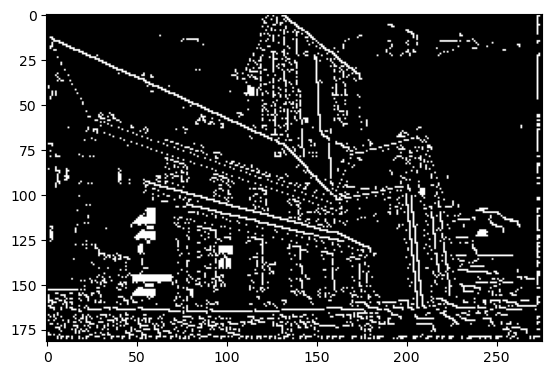

In [10]:
HYSTimg = hystThresh(NMSimg, 2, 50)
plt.imshow(HYSTimg, cmap = 'gray')

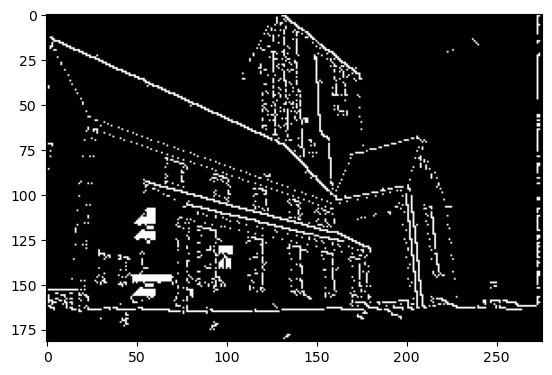

In [11]:
#Final Program
def cannyEdge(img, sigma, lowT, highT):

    kernel = gausKernel(sigma)
    convImg = gausConvolution(img, kernel)
    sobelImg, direction = sobel(convImg)
    nmsImg = nonMaxSup(sobelImg, direction)
    binaryImg = hystThresh(nmsImg, lowT, highT)

    return binaryImg

cannyImg = cannyEdge(image1, 1, 1, 150)
plt.imshow(cannyImg, cmap = 'gray')

## Assignment 3 Question 3

In [12]:
from sklearn.cluster import KMeans

In [13]:
#We must use at least 3 K's to compare the results
K1 = 2
K2 = 3
K3 = 7

In [14]:
#Reshaping image for KMeans use
image2 = np.reshape(image1, (-1, 3))

#Using sklearn.cluster for KMeans
kMeans1 = KMeans(n_clusters = K1).fit(image2)
kMeans2 = KMeans(n_clusters = K2).fit(image2)
kMeans3 = KMeans(n_clusters = K3).fit(image2)

In [15]:
#Getting our labels
result1 = kMeans1.predict(image2)
result2 = kMeans2.predict(image2)
result3 = kMeans3.predict(image2)

#Recreating images
img1 = kMeans1.cluster_centers_[result1].reshape(image1.shape)
img2 = kMeans2.cluster_centers_[result2].reshape(image1.shape)
img3 = kMeans3.cluster_centers_[result3].reshape(image1.shape)

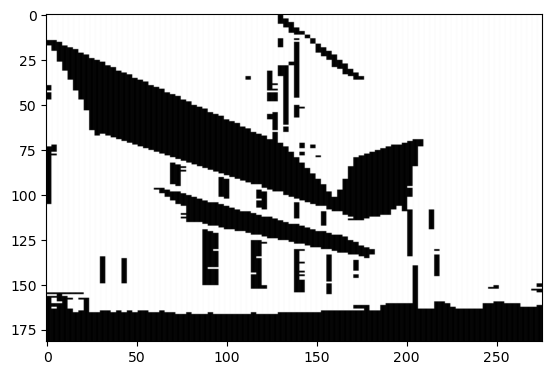

In [16]:
plt.imshow(img1, cmap = 'gray')

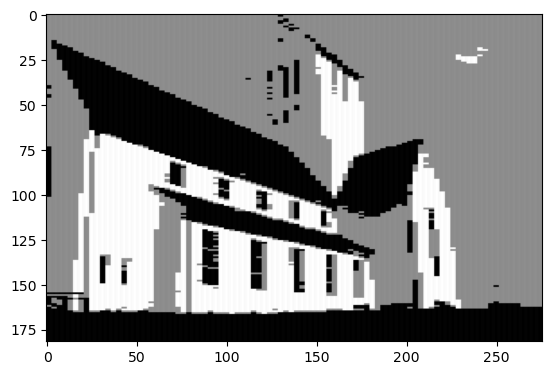

In [17]:
plt.imshow(img2, cmap = 'gray')

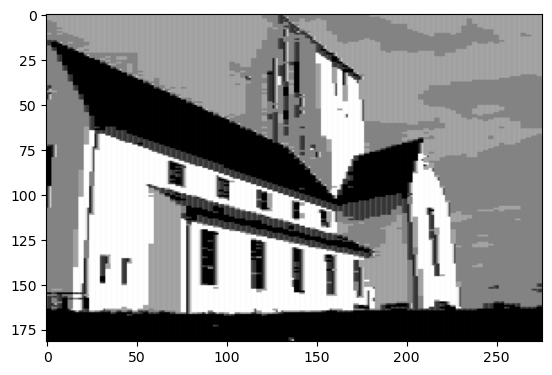

In [18]:
plt.imshow(img3, cmap = 'gray')

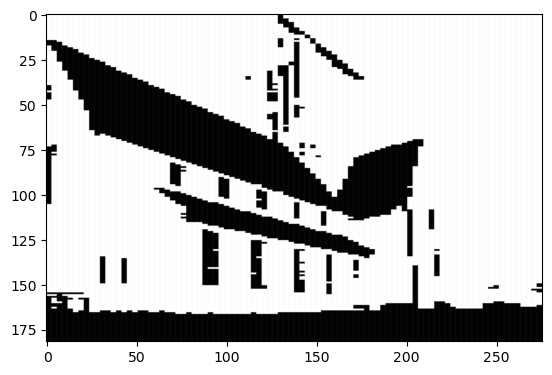

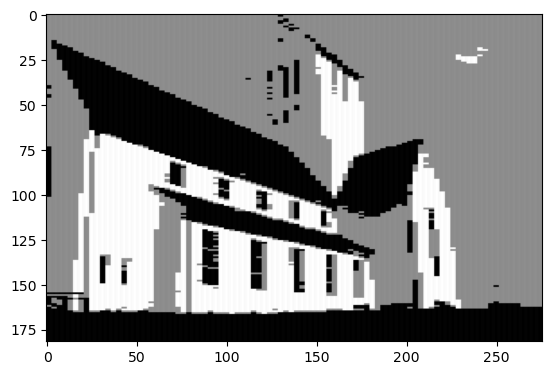

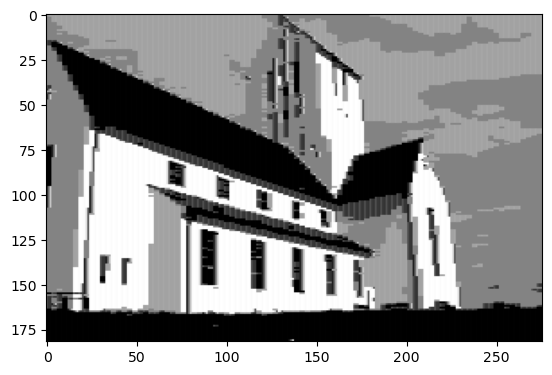

In [19]:
def kMeanAlg(image, numK, kVals):
    
    image2 = np.reshape(image, (-1, 3))

    #Using sklearn.cluster for KMeans
    for i in range(numK):
        kMeans = KMeans(n_clusters = kVals[i]).fit(image2)
        result = kMeans.predict(image2)
        img = kMeans.cluster_centers_[result].reshape(image.shape)

        plt.figure(i)
        plt.imshow(img, cmap = 'gray')

    return None

kMeanAlg(image1, 3, [2, 3, 7])